<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Transformer/Tabular/TabTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
pip install -qU torch

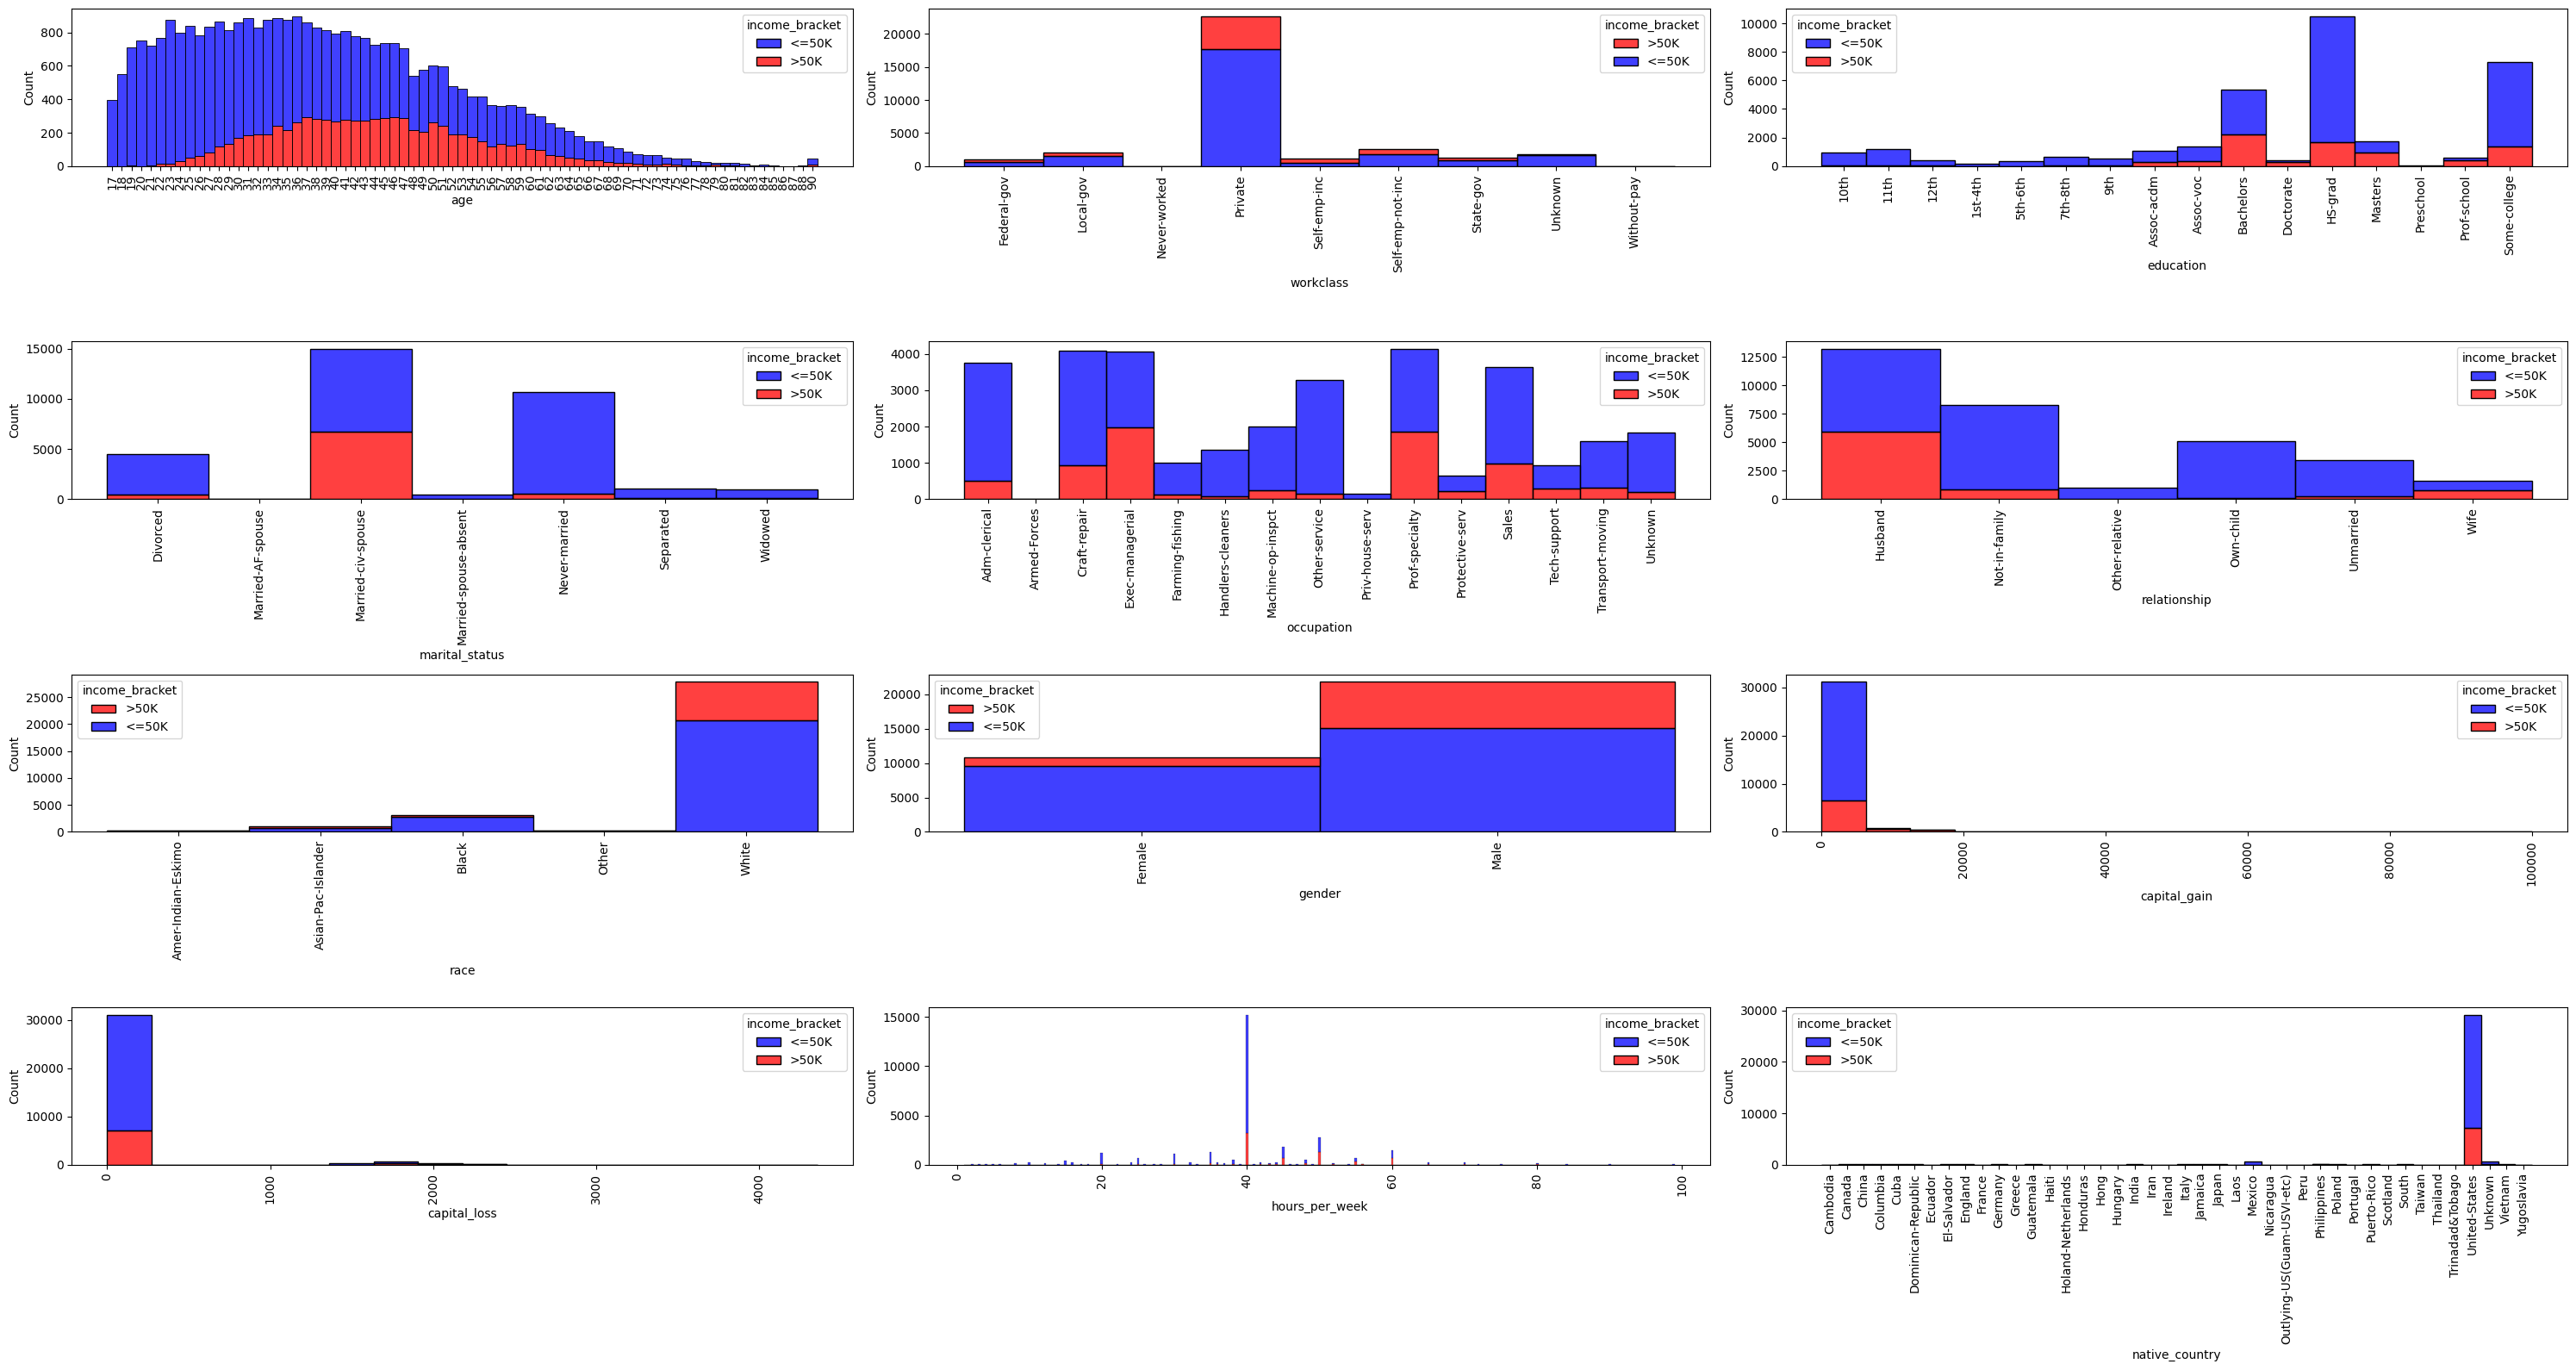

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

CSV_HEADERS = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income_bracket']

train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df_train = pd.read_csv(train_url, header=None, names=CSV_HEADERS)
df_train = df_train.drop(columns=['fnlwgt', 'education_num']).reset_index(drop=True)

cols = df_train.columns
target_cols = ['income_bracket']
numeric_cols = ['capital_gain', 'capital_loss', 'hours_per_week']
categorical_cols = [c for c in cols if c not in target_cols + numeric_cols]

def clean_data(df):
    df[numeric_cols] = df[numeric_cols].astype('float32')
    df[categorical_cols] = df[categorical_cols].astype(str)\
        .apply(lambda s: s.str.strip())
    df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')
    df[target_cols] = df[target_cols].astype(str)\
        .apply(lambda s: s.str.strip().str.replace('.', '', regex=False))
    return df

df_train = clean_data(df=df_train)

test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
df_test = pd.read_csv(test_url, header=None, names=CSV_HEADERS, skiprows=1)
df_test = df_test.drop(columns=['fnlwgt', 'education_num']).reset_index(drop=True)
df_test = clean_data(df=df_test)

plot_x_cols = df_train.columns.drop(target_cols)
custom_palette = {'<=50K':'blue', '>50K':'red'}
ncols = 3
nrows = len(plot_x_cols)//ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 4*nrows))
for ax, col in zip(axes.flatten(), plot_x_cols):
    df_plot = df_train[[col, *target_cols]].sort_values(by=col).copy()
    sns.histplot(ax=ax, data=df_plot, x=col, hue=target_cols[0],
        palette=custom_palette, multiple='stack')
    ax.tick_params(axis='x', labelrotation=90)
fig.tight_layout()
plt.show()

In [2]:
import os
from sklearn import preprocessing
import torch
torch.manual_seed(seed=42)
torch.cuda.manual_seed_all(seed=42)

y_lb = preprocessing.LabelBinarizer()
y_train = y_lb.fit_transform(y=df_train[target_cols]).astype(int).squeeze()
y_test = y_lb.transform(y=df_test[target_cols]).astype(int).squeeze()

num_scaler = preprocessing.StandardScaler()
X_num_train = num_scaler.fit_transform(X=df_train[numeric_cols]).astype('float32')
X_num_test = num_scaler.transform(X=df_test[numeric_cols]).astype('float32')

cat_encoder = preprocessing.OrdinalEncoder(unknown_value=-1,
    handle_unknown='use_encoded_value')
X_cat_train = 1 + cat_encoder.fit_transform(X=df_train[categorical_cols]).astype(int)
X_cat_test = 1 + cat_encoder.transform(X=df_test[categorical_cols]).astype(int)

class CensusDataset(torch.utils.data.Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(data=X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(data=X_cat, dtype=torch.long)
        self.y = torch.tensor(data=y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

ds_temp = CensusDataset(X_num=X_num_train, X_cat=X_cat_train, y=y_train)
ds_train, ds_val = torch.utils.data.random_split(dataset=ds_temp, lengths=[0.8, 0.2],
    generator=torch.Generator().manual_seed(42))
dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=256,
    shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
dl_val = torch.utils.data.DataLoader(dataset=ds_val, batch_size=256,
    shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

ds_test = CensusDataset(X_num=X_num_test, X_cat=X_cat_test, y=y_test)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, batch_size=256,
    shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
print(f"Train size: %d, Val size: %d, Test size: %d"%(
    len(dl_train.dataset), len(dl_val.dataset), len(dl_test.dataset)))

Train size: 26049, Val size: 6512, Test size: 16281


In [5]:
import torch
torch.manual_seed(seed=42)
torch.cuda.manual_seed_all(seed=42)

class TabTransformer(torch.nn.Module):
    def __init__(self, num_features, cat_cardinalities, embedding_dim=16, use_cls=True):
        super().__init__()
        self.embedding_layers = torch.nn.ModuleList(modules=[
            torch.nn.Embedding(num_embeddings=c, embedding_dim=embedding_dim,
                padding_idx=0) for c in cat_cardinalities
        ])

        self.use_cls = use_cls
        if use_cls:
            self.cls_token = torch.nn.Parameter(data=torch.zeros(
                size=(1, 1, embedding_dim)))
            torch.nn.init.normal_(tensor=self.cls_token, mean=0.0, std=0.02)

        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=4, dim_feedforward=4*embedding_dim,
            dropout=0.3, batch_first=True, activation=torch.nn.functional.gelu
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(
            encoder_layer=encoder_layer, num_layers=4
        )
        self.emb_dropout = torch.nn.Dropout(p=0.1)
        self.norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

        in_features = num_features + embedding_dim
        self.fc = torch.nn.Sequential()
        for h in [64, 32]:
            self.fc.append(torch.nn.Linear(in_features=in_features, out_features=h))
            self.fc.append(torch.nn.ReLU())
            self.fc.append(torch.nn.Dropout(p=0.3))
            in_features = h
        self.fc.append(torch.nn.Linear(in_features, 1))

    def forward(self, X_num, X_cat):
        X_emb = [emb(X_cat[:, i]) for i, emb in enumerate(self.embedding_layers)]
        X_emb = torch.stack(tensors=X_emb, dim=1)

        if self.use_cls:
            B = X_emb.size(0)
            cls_tokens = self.cls_token.expand(B, -1, -1)
            X_emb = torch.cat(tensors=[cls_tokens, X_emb], dim=1)

        X_emb = self.emb_dropout(X_emb)
        X_emb = self.transformer_encoder(X_emb)

        if self.use_cls:
            X_emb = X_emb[:, 0, :]
        else:
            X_emb = torch.mean(input=X_emb, dim=1)
        X_emb = self.norm(X_emb)
        X = torch.cat(tensors=[X_num, X_emb], dim=1)
        return self.fc(X)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TabTransformer(num_features=num_scaler.n_features_in_,
    cat_cardinalities=[len(c)+1 for c in cat_encoder.categories_])
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: %d"%(total_params))

Total parameters: 19505


In [ ]:
import torch
torch.manual_seed(seed=42)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
    lr=1e-3, weight_decay=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0.0, 0.0
    for X_num, X_cat, y in dataloader:
        X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        y_pred = model(X_num=X_num, X_cat=X_cat)
        loss = loss_fn(input=y_pred, target=y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=-1)==y).sum().item()
    train_loss /= len(dataloader)
    train_acc /= size
    return train_loss, train_acc

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for X_num, X_cat, y in dataloader:
            X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
            y_pred = model(X_num=X_num, X_cat=X_cat)
            test_loss += loss_fn(input=y_pred, target=y).item()
            test_acc += (y_pred.argmax(dim=-1)==y).sum().item()
    test_loss /= len(dataloader)
    test_acc /= size
    return test_loss, test_acc

def train_model(model, dl_train, dl_val, loss_fn, optimizer,
        epochs, save_path):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.1, patience=3)

    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'train_acc':[],
        'val_loss': [], 'val_acc': []
    }
    for epoch in range(epochs):
        train_loss, train_acc = train(dataloader=dl_train, model=model,
            loss_fn=loss_fn, optimizer=optimizer)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = test(dataloader=dl_val, model=model, loss_fn=loss_fn)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

    return model, history

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    metrics = ['loss', 'acc']
    ncols = 2
    nrows = len(metrics)//2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
    for ax, m in zip(axes.flatten(), metrics):
        sns.lineplot(ax=ax, data=df_history, label='train',
            x='epoch', y=f"train_{m}")
        try:
            sns.lineplot(ax=ax, data=df_history, label='val',
                x='epoch', y=f"val_{m}")
        except Exception:
            pass
        ax.legend(loc="best")
        ax.set_xlabel(xlabel="epoch")
        ax.set_ylabel(ylabel=m)
        ax.set_title(label=f"{m} vs. epoch")
    fig.tight_layout()
    plt.show()

In [ ]:
import time
import torch
torch.manual_seed(seed=42)

start_time = time.time()
save_path='census_classifier.pth'
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_val,
    loss_fn=loss_fn, optimizer=optimizer, epochs=100, save_path=save_path)
print(f"Training duration: %.2fs"%(time.time()-start_time))

plot_history(history=history)

model.load_state_dict(torch.load(save_path, weights_only=True))
test_loss, test_acc = test(dataloader=dl_test, model=model, loss_fn=loss_fn)
print(f"test loss:%.4f, test acc:%.4f"%(test_loss, test_acc))

In [ ]:
import torch
torch.manual_seed(seed=42)

x_num, x_cat, y = ds_test[1979]
model.eval()
with torch.no_grad():
    x_num, x_cat = x_num[None, ...].to(device), x_cat[None, ...].to(device)
    y_pred = model(X_num=x_num, X_cat=x_cat)

classes = ["<=50K", ">50K"]
predicted, actual = classes[y_pred.argmax(dim=-1)], classes[y]

print(f"Predicted: %s, Actual: %s"%(predicted, actual))

Predicted: >50K, Actual: <=50K
